In [1]:
import pandas as pd
from scipy.stats import norm 
import numpy as np
from scipy.optimize import brentq
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from scipy import interpolate
from scipy.interpolate import CubicSpline

## Import Data

In [2]:
swaption=pd.read_excel('IR Data.xlsx',sheet_name='Swaption',header=0,skiprows=2)
swaption= swaption.iloc[0:15,0:13]
swaption= swaption.set_index(["Expiry","Tenor"])

#import Q1 dataset
ois = pd.read_csv("ois.csv",index_col=0)
ois = ois.rename(columns={'Tenor.1':'Tenor'})
irs = pd.read_csv("irs.csv",index_col=0)
irs = irs.rename(columns={'Tenor.1':'Tenor'})
forward_swap_rates = pd.read_csv("forward_swap_rates.csv")

In [3]:
strike_vol = pd.DataFrame(columns=['forward','tenor','strike','impl_vol'])
Expiry=np.array(["1Y","5Y","10Y"])
Tenor=np.array(["1Y","2Y","3Y","5Y","10Y"])
s=np.array([-200,-150,-100,-50,-25,0,25,50,100,150,200])

In [4]:
strike_vol = pd.DataFrame(columns=['expiry','tenor','forward','strike','impl_vol','type'])
m=0
for index,row in forward_swap_rates.iterrows():
    n=0
    for i in swaption.iloc[[m]]:
        if (n>=5):
            new_row = {"expiry":row['forward'],"tenor":row['tenor'],"forward":row['forward_swap_rate'],"strike":(row['forward_swap_rate']+(s[n]/10000)),"impl_vol":swaption.iloc[[m]][i].values[0],'type':'pay'}
            n+=1
        else:
            new_row = {"expiry":row['forward'],"tenor":row['tenor'],"forward":row['forward_swap_rate'],"strike":(row['forward_swap_rate']+(s[n]/10000)),"impl_vol":swaption.iloc[[m]][i].values[0],'type':'rec'}
            n+=1
        strike_vol = strike_vol.append(new_row,ignore_index=True)
    m+=1

In [5]:
def PVBP(expiry,tenor,coupon_period=0.5):
    i=expiry
    j=tenor
    sum_of_df_fixed = ois.loc[(ois.index>i)&(ois.index<=i+j)]['Do'].sum()

    return float((coupon_period*sum_of_df_fixed))

## Displace Diffusion Calibration

In [6]:
def DisplacedDiffusion( F, K, sigma, expiry, tenor, Beta, Option_type):
    if Beta == 0:
        d1 = (K - F) / (sigma*F*np.sqrt(expiry))
        if Option_type == 'pay':
            return PVBP(expiry,tenor)*((F - K)*norm.cdf(-d1) + (sigma*F*np.sqrt(expiry)*norm.pdf(-d1)))
        elif Option_type == 'rec':
            return PVBP(expiry,tenor)*((K - F)*norm.cdf(d1) + (sigma*F*np.sqrt(expiry)*norm.pdf(d1)))

    else:
        d1 = (np.log((K*Beta/F) + 1 - Beta) + (0.5*(sigma**2)*(Beta**2)*expiry)) / (sigma*Beta*np.sqrt(expiry))
        d2 = d1-(sigma*Beta*np.sqrt(expiry))
        if Option_type == 'pay':
            return PVBP(expiry,tenor)*((F/Beta*norm.cdf(-d2)) - (((1-Beta)/Beta)*F + K)*norm.cdf(-d1))
        elif Option_type == 'rec':
            return PVBP(expiry,tenor)*(((1-Beta)/Beta*F + K)*norm.cdf(d1) - F/Beta*norm.cdf(d2))


In [7]:
def DD_Calibration(x,ATM,strikes,expiry,tenor,vols,types):
    err=0.0
    for k,vol,type in zip(range(len(strikes)), vols, types):
        discounted_price1 = DisplacedDiffusion(ATM, strikes[k], vol, expiry, tenor, 1, type) 
        discounted_price2 = DisplacedDiffusion(ATM, strikes[k], x[0], expiry, tenor, x[1], type)
        err += (discounted_price1 - discounted_price2)**2
    return err

initialGuess_DD=[0.5,0.2]

In [8]:
expiries = [1,5,10]
tenors = [1,2,3,5,10]
beta_calibrated=pd.DataFrame(np.zeros((3,5)),index=expiries,columns=tenors)
sigma_calibrated=pd.DataFrame(np.zeros((3,5)),index=expiries,columns=tenors)

In [9]:
for i in expiries:
    for j in tenors:
        new_strike_vol = strike_vol[(strike_vol['expiry']==i)&(strike_vol['tenor']==j)]
        strikes = new_strike_vol['strike'].values
        ATM = strikes[5]
        types = new_strike_vol['type'].values
        vols = new_strike_vol['impl_vol'].values/100
        res = least_squares(lambda x: DD_Calibration(x,
                                          ATM,
                                          strikes,
                                          i,   
                                          j,
                                          vols,
                                          types
                                          ),
                                          initialGuess_DD,
                                          bounds=([0,0],[np.inf,1]))
        beta_calibrated[j][i]= res.x[1]
        sigma_calibrated[j][i]=res.x[0]

print('Sigma')
print(sigma_calibrated)

print('Beta')
print(beta_calibrated)

Sigma
          1         2         3         5         10
1   0.403513  0.364004  0.333004  0.290867  0.252750
5   0.307372  0.312846  0.308549  0.269958  0.247289
10  0.300011  0.297105  0.294438  0.265706  0.242692
Beta
          1         2         3         5         10
1   0.199525  0.199182  0.199020  0.199484  0.200038
5   0.198502  0.198071  0.365665  0.345178  0.341136
10  0.693502  0.254469  0.233068  0.293269  0.264678


In [30]:
beta_calibrated.to_csv("beta_calibrated.csv")
sigma_calibrated.to_csv("sigma_calibrated.csv")

## Displace Diffusion Interpolation

In [10]:
expiries_interpolated = [1,2,3,4,5,6,7,8,9,10]
sigma_interpolated = pd.DataFrame(np.zeros((10,5)),index=expiries_interpolated,columns=tenors)
beta_interpolated =pd.DataFrame(np.zeros((10,5)),index=expiries_interpolated,columns=tenors)

In [11]:
for j in tenors:
    y_beta = beta_calibrated[j].values.tolist()
    y_sigma = sigma_calibrated[j].values.tolist()
    x = expiries
    
    cs_beta = CubicSpline(x, y_beta, extrapolate=True)
    cs_sigma = CubicSpline(x, y_sigma, extrapolate=True)
    for i in expiries_interpolated:
        try:
            beta_interpolated[j][i] = beta_calibrated[j][i]
            sigma_interpolated[j][i] = sigma_calibrated[j][i]
        except:
            beta_interpolated[j][i]=cs_beta(i)
            sigma_interpolated[j][i]=cs_sigma(i)

In [12]:
# beta_interpolated.to_pickle('beta_interpolated.pickle')
# sigma_interpolated.to_pickle('sigma_interpolated.pickle')

## SABR Calibration

In [12]:
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    if F == K:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom
    return sabrsigma


In [13]:
def sabr_calibration(x, strikes, vols, F, T):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], 0.9, x[1], x[2]))**2
    return err

In [14]:
SABR_Alpha=pd.DataFrame(np.zeros((3,5)),index=expiries,columns=tenors)
SABR_Rho=pd.DataFrame(np.zeros((3,5)),index=expiries,columns=tenors)
SABR_Nu=pd.DataFrame(np.zeros((3,5)),index=expiries,columns=tenors)

In [15]:
initialGuess_sabr=[0.1,-0.5,0.5]

for i in expiries:
    for j in tenors:
        new_strike_vol = strike_vol[(strike_vol['expiry']==i)&(strike_vol['tenor']==j)]
        strikes = new_strike_vol['strike'].values
        ATM = strikes[5]
        vols = new_strike_vol['impl_vol'].values/100

        res=least_squares(lambda x: sabr_calibration(x,
                                           strikes,
                                           vols,
                                           ATM,
                                           i),
                          initialGuess_sabr,
                          bounds=([0,-1,0],[np.inf,1,np.inf]))
        SABR_Alpha[j][i]=res.x[0]
        SABR_Rho[j][i]=res.x[1]
        SABR_Nu[j][i]=res.x[2]

print('Alpha')
print(SABR_Alpha)
print('Rho')
print(SABR_Rho)
print('Nu')
print(SABR_Nu)


Alpha
          1         2         3         5         10
1   0.139066  0.184648  0.196850  0.178045  0.171016
5   0.166485  0.199501  0.210353  0.191054  0.177187
10  0.177498  0.195424  0.206884  0.201900  0.181174
Rho
          1         2         3         5         10
1  -0.633239 -0.525106 -0.482838 -0.414385 -0.264052
5  -0.584922 -0.546875 -0.549788 -0.511244 -0.438524
10 -0.545406 -0.544690 -0.549852 -0.563508 -0.511984
Nu
          1         2         3         5         10
1   2.049463  1.677344  1.438095  1.064930  0.778611
5   1.339204  1.061894  0.936663  0.671505  0.495665
10  1.006104  0.925096  0.867641  0.719476  0.577374


In [31]:
SABR_Alpha.to_csv("SABR_Alpha.csv")
SABR_Nu.to_csv("SABR_Nu.csv")
SABR_Rho.to_csv("SABR_Rho.csv")

## SABR Interpolation

In [16]:
tenor_full_range = [1,2,3,5,10]
forward_full_range = []
for i in range(40):
    i+=1
    forward_full_range.append(i/4)

In [17]:
SABR_Alpha_full=pd.DataFrame(np.zeros((40,5)),index=forward_full_range,columns=tenor_full_range)
SABR_Rho_full=pd.DataFrame(np.zeros((40,5)),index=forward_full_range,columns=tenor_full_range)
SABR_Nu_full=pd.DataFrame(np.zeros((40,5)),index=forward_full_range,columns=tenor_full_range)

In [18]:
for j in tenor_full_range:
    y_alpha = SABR_Alpha[j].values.tolist()
    x_alpha = SABR_Alpha.index.tolist()
    y_rho = SABR_Rho[j].values.tolist()
    x_rho = SABR_Rho.index.tolist()
    y_nu = SABR_Nu[j].values.tolist()
    x_nu = SABR_Nu.index.tolist()
    cs_alpha = CubicSpline(x_alpha, y_alpha, extrapolate=True)
    cs_rho = CubicSpline(x_rho, y_rho, extrapolate=True)
    cs_nu = CubicSpline(x_nu, y_nu, extrapolate=True)
    for i in forward_full_range:
        try:
            SABR_Alpha_full[j][i] = SABR_Alpha[j][i]
            SABR_Rho_full[j][i] = SABR_Rho[j][i]
            SABR_Nu_full[j][i] = SABR_Nu[j][i]
        except:
            SABR_Alpha_full[j][i]=cs_alpha(i)
            SABR_Rho_full[j][i]=cs_rho(i)
            SABR_Nu_full[j][i]=cs_nu(i)

In [19]:
def par_swap(expiry,tenor):
    i=expiry
    j=tenor
    sum_of_df_fixed = ois.loc[(ois.index>i)&(ois.index<=i+j)]['Do'].sum()
    sum_of_do_li = 0
    for k in range(int(j*2)):
        k=k/2+0.5
        sum_of_do_li += ois.loc[ois.index==i+k]['Do'].sum()*irs.loc[irs.index==i+k]['Li'].sum()

    return sum_of_do_li/sum_of_df_fixed

#  Payer 2y x 10 y

In [20]:
payer_expiry = 2
payer_tenor = 10

In [21]:
strikes = []
for i in range(8):
    strikes.append((i+1)/100)
strikes

[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]

### DD model

In [22]:
payer_beta = beta_interpolated[payer_tenor][payer_expiry]
payer_sigma = sigma_interpolated[payer_tenor][payer_expiry]
payer_F = par_swap(payer_expiry,payer_tenor)

payer_DD = []
for K in strikes:
    payer_DD.append(DisplacedDiffusion(payer_F, K, payer_sigma, payer_expiry, payer_tenor, payer_beta, "pay"))

### SABR Model

In [23]:
payer_alpha = SABR_Alpha_full[payer_tenor][payer_expiry]
payer_rho = SABR_Rho_full[payer_tenor][payer_expiry]
payer_nu = SABR_Nu_full[payer_tenor][payer_expiry]

payer_SABR = []
for K in strikes:
    payer_SABR.append(DisplacedDiffusion(payer_F,K,SABR(payer_F,K,payer_expiry,payer_alpha,0.9,payer_rho,payer_nu),payer_expiry,payer_tenor,1,"pay"))

In [24]:
strikes_percent = []
for K in strikes:
    strikes_percent.append(str(int(K*100))+"%")
payer_price_df = pd.DataFrame(index=strikes_percent,columns=['SABR','DD'])
payer_price_df['SABR']=payer_SABR
payer_price_df['DD']=payer_DD
payer_price_df

,SABR,DD
1%,0.289538,0.288039
2%,0.197941,0.194383
3%,0.114767,0.112193
4%,0.051919,0.052785
5%,0.020918,0.019697
6%,0.010110,0.005802
7%,0.005992,0.001364
8%,0.004060,0.000261


#  Receiver 8y x 10 y

In [25]:
rec_expiry = 8
rec_tenor = 10

### DD Model

In [26]:
rec_beta = beta_interpolated[rec_tenor][rec_expiry]
rec_sigma = sigma_interpolated[rec_tenor][rec_expiry]
rec_F = par_swap(rec_expiry,rec_tenor)

rec_DD = []
for K in strikes:
    rec_DD.append(DisplacedDiffusion(rec_F, K, rec_sigma, rec_expiry, rec_tenor, rec_beta, "rec"))

### SABR Model

In [27]:
rec_alpha = SABR_Alpha_full[rec_tenor][rec_expiry]
rec_rho = SABR_Rho_full[rec_tenor][rec_expiry]
rec_nu = SABR_Nu_full[rec_tenor][rec_expiry]

rec_SABR = []
for K in strikes:
    rec_SABR.append(DisplacedDiffusion(rec_F,K,SABR(rec_F,K,rec_expiry,rec_alpha,0.9,rec_rho,rec_nu),rec_expiry,rec_tenor,1,"rec"))

In [28]:
rec_price_df = pd.DataFrame(index=strikes_percent,columns=['SABR','DD'])
rec_price_df['SABR']=rec_SABR
rec_price_df['DD']=rec_DD
rec_price_df

,SABR,DD
1%,0.015851,0.011497
2%,0.034005,0.026047
3%,0.056982,0.050307
4%,0.087386,0.085864
5%,0.128926,0.133068
6%,0.185074,0.191166
7%,0.255506,0.258676
8%,0.335874,0.333805


In [36]:
# payer_price_df.to_csv("payer_price_df.csv")
# rec_price_df.to_csv("rec_price_df.csv")

In [29]:
def ImpliedVolDD_1(F,K,sigma,expiry,tenor,beta,type):
    try:
        impliedVol = brentq(lambda x: DisplacedDiffusion(F,K,sigma,expiry,tenor,beta,type) -
                            DisplacedDiffusion(F, K, x, expiry, tenor, 1, type),
                            1e-6, 10)
    except Exception:
        impliedVol = np.nan

    return impliedVol

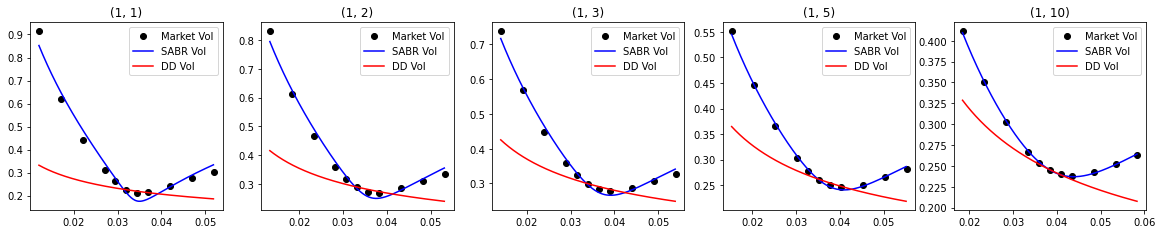

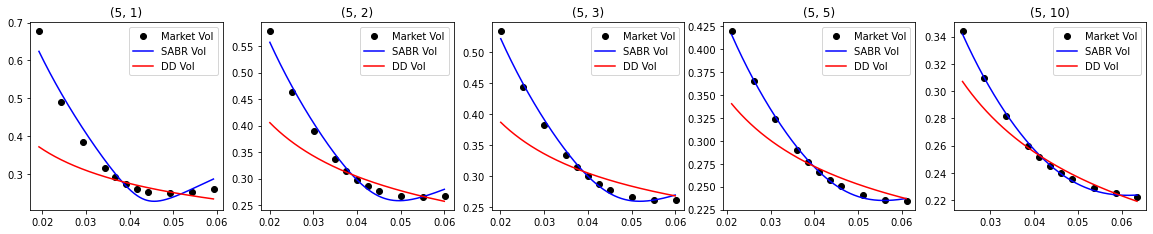

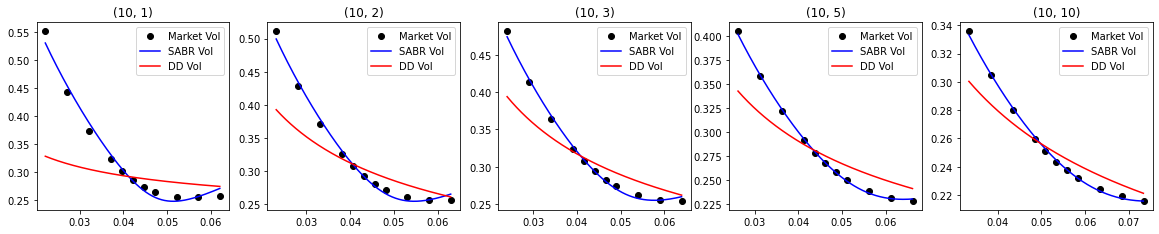

In [80]:
initialGuess = 0.5
ATM_vols_df = []

for i in expiries:
    
    fig=plt.figure(figsize=(20,20))
    ax=plt.axes()
    ax=plt.title('Tenor=%s' %j)
    u=0
    for j in tenors:
        
        ax=plt.subplot(551+u)
        u+=1
        sabrvols = []
        ddvols = []
        strikes_list = []
        types_list = []
        

        ATM = strike_vol[(strike_vol['expiry']==i)&(strike_vol['tenor']==j)]['forward'].to_list()[0]
        strike_list=strike_vol[(strike_vol['expiry']==i)&(strike_vol['tenor']==j)]['strike']
        beta_value = beta_calibrated[j][i]
        Market_vols = strike_vol[(strike_vol['expiry']==i)&(strike_vol['tenor']==j)]['impl_vol'].to_list()
        Market_vols = [number / 100 for number in Market_vols]
        ATM_vols = strike_vol[(strike_vol['expiry']==i)&(strike_vol['tenor']==j)]['impl_vol'].to_list()[5]/100
        type_list = strike_vol[(strike_vol['expiry']==i)&(strike_vol['tenor']==j)]['type']
        ATM_strike=strike_vol[(strike_vol['expiry']==i)&(strike_vol['tenor']==j)]['strike'].to_list()[5]  
        for n in range(400):
            n=n/10000-(400/20000)
            strikes_list.append(ATM_strike+n)
            if n >= 0:
                types_list.append('pay')
            else:
                types_list.append('rec') 

            
        for K,type in zip(strikes_list,types_list):
            sabrvols.append(SABR(ATM, K, i, SABR_Alpha[j][i], 0.9, SABR_Rho[j][i], SABR_Nu[j][i]))
            ddvols.append(ImpliedVolDD_1(ATM, K, ATM_vols ,i, j, beta_value,type))
            
        #insert plot graphs here
        ax=plt.plot(strike_list,Market_vols,color='black',marker='o',linestyle='None',label='Market Vol')
        ax=plt.plot(strikes_list,sabrvols,color='blue',label='SABR Vol')
        ax=plt.plot(strikes_list,ddvols,color='red',label='DD Vol')
        ax=plt.title((i,j))
        ax=plt.legend()
    plt.savefig('%s'%i,dpi=100)
    plt.show()
